## Benchmarking gradient BO

We benchmark the gradient-based BO provided by BoTorch on traditional test functions. 
Note that the implementation provided by BoTorch only leverages gradients in the conditioning of the GP, 
not in the acquisition function itself.

In [1]:
# Imports
import os

import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

from botorch import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.acquisition import qKnowledgeGradient, qNoisyExpectedImprovement
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.models.gpytorch import GPyTorchModel
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.models.model import FantasizeMixin
from botorch.models.gpytorch import GPyTorchModel

from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood


In [2]:
# Set default data type to avoid numerical issues from low precision
torch.set_default_dtype(torch.double)

# Set seed for consistency and good results
seed = 3
torch.manual_seed(seed)
np.random.seed(seed)

In [65]:
# Parameters
f_noise = 0.01 # Noise added to both function evaluations and their gradients
rs_init = 3 # Initialization points from random search
rb_dim = 3 # Dimension of the optimization problem.
d_min = -5.12 # Lower bound of search space for each dimension of the domain
d_max = 5.12 # Upper bound of search space for each dimension of the domain
bo_iters = 40 # Number of iterations of Bayesian Optimization
mc_samples = 256 # Samples from Monte-Carlo sampler

## Derivative-enabled Gaussian Process (dGP)

We create a custom BoTorch dGP model using GPyTorch. This model requires modifying the mean and covariance matrix to incorporate gradient/derivative information. As such, a mean *vector* and the covariance matrix of the RBF kernel are used [2]. This class was modified from this [GPyTorch tutorial](https://docs.gpytorch.ai/en/latest/examples/08_Advanced_Usage/Simple_GP_Regression_Derivative_Information_1d.html). 


In [66]:
# Define the dGP
class GPWithDerivatives(GPyTorchModel, gpytorch.models.ExactGP, FantasizeMixin):
    def __init__(self, train_X, train_Y):
        # Dimension of model
        dim = train_X.shape[-1] 
        # Multi-dimensional likelihood since we're modeling a function and its gradient
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=1 + dim)
        super().__init__(train_X, train_Y, likelihood)
        # Gradient-enabled mean
        self.mean_module = gpytorch.means.ConstantMeanGrad() 
        # Gradient-enabled kernel
        self.base_kernel = gpytorch.kernels.RBFKernelGrad( 
            ard_num_dims=dim, # Separate lengthscale for each input dimension
        )
        # Adds lengthscale to the kernel
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        # Output dimension is 1 (function value) + dim (number of partial derivatives)
        self._num_outputs = 1 + dim
        # Used to extract function value and not gradients during optimization
        self.scale_tensor = torch.tensor([1.0] + [0.0]*dim, dtype=torch.double)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class myGP(GPyTorchModel, gpytorch.models.ExactGP, FantasizeMixin):
    def __init__(self, train_X, train_Y):
        # Dimension of model
        dim = train_X.shape[-1] 
        # Multi-dimensional likelihood since we're modeling a function and its gradient
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(train_X, train_Y, likelihood)
        # Gradient-enabled mean
        self.mean_module = gpytorch.means.ConstantMeanGrad() 
        # Gradient-enabled kernel
        self.base_kernel = gpytorch.kernels.RBFKernelGrad( 
            ard_num_dims=dim, # Separate lengthscale for each input dimension
        )
        # Adds lengthscale to the kernel
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        # Output dimension is 1 (function value)
        self._num_outputs = 1

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Random Search

To initialize our GP we obtain initialization data using random search on the optimization domain $[-2,2]^3$.

In [67]:
# Random search locations
init_X = torch.rand((rs_init, rb_dim))*(d_max - d_min)+d_min
init_X = torch.autograd.Variable(init_X,requires_grad=True)

In [68]:
import botorch.test_functions
Rastrigin = botorch.test_functions.synthetic.Rastrigin(dim=rb_dim)
Rosenbrock = botorch.test_functions.synthetic.Rosenbrock(dim=rb_dim)

def f(x):
    return - Rosenbrock.evaluate_true(x)

In [69]:
# Populate random search evaluations
init_Y = torch.empty((rs_init, rb_dim + 1))
for i in range(rs_init):
    obj = f(init_X[i])
    obj.backward()
    deriv = init_X.grad[i]
    init_Y[i][0] = obj
    init_Y[i][1:] = deriv
init_X = init_X.detach()
init_Y = init_Y.detach()

## qNEI FOBO Loop

Here we have the FOBO loop with the qNEI acquisition function on a dGP. Note that we have to include a `ScalarizedPosteriorTransform` to ensure that we're optiming over the black-box function's function evaluation instead of its gradients (since the output of the dGP is a mean vector of the black-box function's value and gradients, as opposed to a mean scalar of just the black-box function's value). Also, we scale the domain and range of the training data [to avoid numerical issues](https://github.com/pytorch/botorch/issues/1745).

In [70]:
train_X, train_Y = init_X.clone(), init_Y.clone()
for i in range(bo_iters):
    # Standardize domain and range, this prevents numerical issues
    mean_Y = train_Y.mean(dim=0)
    std_Y = train_Y.std(dim=0)
    unscaled_train_Y = train_Y
    scaled_train_Y = (train_Y - mean_Y) / std_Y
    
    mean_X = train_X.mean(dim=0)
    std_X = train_X.std(dim=0)
    unscaled_train_X = train_X
    scaled_train_X = (train_X - mean_X) / std_X

    # Initialize the dGP and fit it to the training data
    dGP_model = GPWithDerivatives(scaled_train_X, scaled_train_Y) # Define dGP model
    mll = ExactMarginalLogLikelihood(dGP_model.likelihood, dGP_model) # Define MLL
    fit_gpytorch_mll(mll, max_attempts=40)

    # Extract only the function value from the multi-output GP, the dGP
    scal_transf = ScalarizedPosteriorTransform(weights=dGP_model.scale_tensor)

    # Create qNEI acquisition function
    sampler = SobolQMCNormalSampler(mc_samples)
    qNEI = qNoisyExpectedImprovement(dGP_model,\
                train_X,\
                sampler,\
                posterior_transform=scal_transf)

    # Set bounds for optimization: [-2,2]^d
    bounds = torch.vstack([torch.tensor([d_min]*rb_dim),\
                           torch.tensor([d_max]*rb_dim)])

    # Rescale bounds based on training data
    bounds = (bounds - mean_X) / std_X

    # Get candidate point for objective
    candidates, _ = optimize_acqf(
        acq_function=qNEI,
        bounds=bounds,
        q=1,
        num_restarts=100,
        raw_samples=512,  # used for intialization heuristic
        options={"batch_limit": 1, "maxiter": 1000},
    )

    # Rescale candidate back to original domain
    candidate = (candidates[0]  * std_X) + mean_X
    candidate = torch.autograd.Variable(candidate,requires_grad=True)
    
    # Evaluate the objective and add it to the list of data for the model
    obj = f(candidate)
    obj.backward()
    deriv = candidate.grad
    new_Y = torch.cat([obj.unsqueeze(0),deriv])
    
    # Append evaluation to training data
    train_X = torch.vstack((train_X, candidate)).detach().clone()
    train_Y = torch.vstack((train_Y, new_Y)).detach().clone()


ModelFittingError: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.

## Run traditional BO.

In [71]:
from botorch.models import SingleTaskGP
train_X_bo, train_Y_bo = init_X.clone(), init_Y[:, 0].clone().reshape(-1, 1)
for i in range(bo_iters):
    # Standardize domain and range, this prevents numerical issues
    mean_Y = train_Y_bo.mean(dim=0)
    std_Y = train_Y_bo.std(dim=0)
    unscaled_train_Y = train_Y_bo
    scaled_train_Y = (train_Y_bo - mean_Y) / std_Y
    
    mean_X = train_X_bo.mean(dim=0)
    std_X = train_X_bo.std(dim=0)
    unscaled_train_X = train_X_bo
    scaled_train_X = (train_X_bo - mean_X) / std_X

    # Initialize the GP and fit it to the training data
    GP_model = SingleTaskGP(train_X=scaled_train_X, train_Y=scaled_train_Y)
    mll = ExactMarginalLogLikelihood(GP_model.likelihood, GP_model) # Define MLL
    fit_gpytorch_mll(mll, max_attempts=40)

    # Create qNEI acquisition function
    sampler = SobolQMCNormalSampler(mc_samples)
    qNEI = qNoisyExpectedImprovement(GP_model,\
                train_X_bo,\
                sampler,\
                )

    # Set bounds for optimization: [-2,2]^d
    bounds = torch.vstack([torch.tensor([d_min]*rb_dim),\
                           torch.tensor([d_max]*rb_dim)])

    # Rescale bounds based on training data
    bounds = (bounds - mean_X) / std_X

    # Get candidate point for objective
    candidates, _ = optimize_acqf(
        acq_function=qNEI,
        bounds=bounds,
        q=1,
        num_restarts=100,
        raw_samples=512,  # used for intialization heuristic
        options={"batch_limit": 1, "maxiter": 1000},
    )

    # Rescale candidate back to original domain
    candidate = (candidates[0]  * std_X) + mean_X
    candidate = torch.autograd.Variable(candidate,requires_grad=True)
    
    # Evaluate the objective and add it to the list of data for the model
    obj = f(candidate)
    new_Y = obj.unsqueeze(0)
    
    # Append evaluation to training data
    train_X_bo = torch.vstack((train_X_bo, candidate)).detach().clone()
    train_Y_bo = torch.vstack((train_Y_bo, new_Y)).detach().clone()


/home/cedric/PostPhD/Dev/BayesOpt/botorch/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/cedric/PostPhD/Dev/BayesOpt/botorch/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/cedric/PostPhD/Dev/BayesOpt/botorch/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/cedric/PostPhD/Dev/BayesOpt/botorch/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/cedric/PostPhD/Dev/BayesOpt/botorch/botorch/models/utils/assorted.py:1

## Plot Results

From plotting the results we see that derivative-enabled Bayesian Optimization is able to utilize gradient information to maximize the objective function.

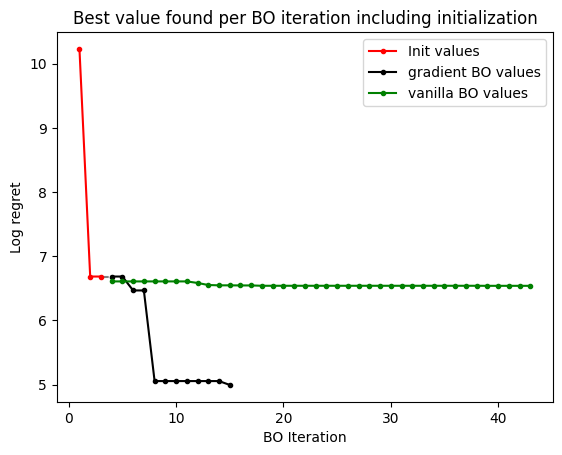

In [76]:
plot_iters = rs_init + bo_iters
# Extract maximum value per iteration
def extract_maxs(Y):
    maxima = torch.zeros(Y.shape[0])
    cur_max = Y[0][0]
    for i in range(Y.shape[0]):
        cur_max = cur_max if cur_max > Y[i][0] else Y[i][0]
        maxima[i] = cur_max
    return maxima
maxima = extract_maxs(train_Y)
maxima_bo = extract_maxs(train_Y_bo)

# Get plotting values
plt_y = np.log(-maxima.numpy())
plt_y_bo = np.log(-maxima_bo.numpy())
plt_x = list(range(1,len(plt_y)+1))
plt_x_bo = list(range(1,len(plt_y_bo)+1))

# Have the first x-value in the plot start at 1 to be consistent with above prints
plt_y = np.hstack([plt_y])
plt_x = np.hstack([plt_x])

# Plot all values
plt.plot([plt_x[rs_init-1], plt_x[rs_init]], [plt_y[rs_init-1], plt_y[rs_init]],\
         linestyle='--', color='gray')
plt.plot(plt_x[0:rs_init], plt_y[0:rs_init], color='red', label="Init values", marker='.')
plt.plot(plt_x[rs_init:], plt_y[rs_init:], color='black', label="gradient BO values", marker='.')
plt.plot(plt_x_bo[rs_init:], plt_y_bo[rs_init:], color='green', label="vanilla BO values", marker='.')

plt.xlabel("BO Iteration")
plt.ylabel("Log regret")
plt.title("Best value found per BO iteration including initialization (Rosenbrock)")
plt.legend()
plt.show()
plt.close()

In [64]:
f(torch.Tensor([10, 1, 1]))

tensor(-980181.)

## qKG FOBO Loop

Here we have the same FOBO loop, but with the qKG acquisition function.


In [ ]:
# Reset training data to the same as for qNEI
train_X = train_X[0:rs_init]
train_Y = train_Y[0:rs_init]

for i in range(bo_iters):
    # Standardize domain and range, this prevents numerical issues
    mean_Y = train_Y.mean(dim=0)
    std_Y = train_Y.std(dim=0)
    unscaled_train_Y = train_Y
    scaled_train_Y = (train_Y - mean_Y) / std_Y
    
    mean_X = train_X.mean(dim=0)
    std_X = train_X.std(dim=0)
    unscaled_train_X = train_X
    scaled_train_X = (train_X - mean_X) / std_X

    # Initialize the dGP and fit it to the training data
    dGP_model = GPWithDerivatives(scaled_train_X, scaled_train_Y) # Define dGP model
    mll = ExactMarginalLogLikelihood(dGP_model.likelihood, dGP_model) # Define MLL
    fit_gpytorch_mll(mll, max_attempts=20)

    # Extract only the function value from the multi-output GP, the dGP
    scal_transf = ScalarizedPosteriorTransform(weights=dGP_model.scale_tensor)

    # Create the qKG acquisition function
    qKG = qKnowledgeGradient(dGP_model,\
                posterior_transform=scal_transf,\
                num_fantasies=5)

    # Set bounds for optimization: [-2,2]^d
    bounds = torch.vstack([torch.tensor([d_min]*rb_dim),\
                           torch.tensor([d_max]*rb_dim)])

    # Rescale domain based on training data
    bounds = (bounds - mean_X) / std_X

    # Get candidate point for objective
    candidates, _ = optimize_acqf(
        acq_function=qKG,
        bounds=bounds,
        q=1,
        num_restarts=100,
        raw_samples=512,  # used for intialization heuristic
        options={"batch_limit": 1, "maxiter": 1000},
    )

    # Rescale candidate back to original domain
    candidate = (candidates[0]  * std_X) + mean_X
    
    # Evaluate the objective and add it to the list of data for the model
    obj, deriv = Rosenbrock(candidate)
    new_Y = torch.cat([obj.unsqueeze(0),deriv])
    
    # Append evaluation to training data
    train_X = torch.vstack((train_X, candidate)).detach().clone()
    train_Y = torch.vstack((train_Y, new_Y)).detach().clone()


## Plot Results

From plotting the results we see that derivative-enabled Bayesian Optimization is able to find better maxima values.

In [ ]:
# Extract maximum value per iteration
maxima = torch.zeros(rs_init + bo_iters)
cur_max = train_Y[0][0]

for i in range(rs_init + bo_iters):
    cur_max = cur_max if cur_max > train_Y[i][0] else train_Y[i][0]
    maxima[i] = cur_max

# Get plotting values
plt_y = maxima.numpy()
plt_x = list(range(1,len(plt_y)+1))

# Have the first x-value in the plot start at 1 to be consistent with above prints
plt_y = np.hstack([plt_y])
plt_x = np.hstack([plt_x])

# Plot all values
plt.plot([plt_x[rs_init-1], plt_x[rs_init]], [plt_y[rs_init-1], plt_y[rs_init]],\
         linestyle='--', color='gray')
plt.plot(plt_x[0:rs_init], plt_y[0:rs_init], color='red', label="Init values", marker='.')
plt.plot(plt_x[rs_init:], plt_y[rs_init:], color='black', label="BO values", marker='.')
plt.xlabel("BO Iteration")
plt.ylabel("Maximum value")
plt.title("Best value found per BO iteration including initialization")
plt.legend()
plt.show()
plt.close()

plt.plot([plt_x[rs_init-1], plt_x[rs_init]], [plt_y[rs_init-1], plt_y[rs_init]],\
         linestyle='--', color='gray')
plt.plot(plt_x[rs_init-1], plt_y[rs_init-1], color='red', label="Init values", marker='.')
plt.plot(plt_x[rs_init:], plt_y[rs_init:], color='black', label="BO values", marker='.')
plt.xlabel("BO Iteration")
plt.ylabel("Maximum value")
plt.title("Best value found per BO iteration after initialization")
plt.legend()
plt.show()
plt.close()